# Постановка задачи.
Необходимо обучить нейросеть, способную по входному изображению лица
определять пол человека.

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import json

In [2]:
general_path = 'C:/internship_data' # зададим путь к данным

Создадим датасет, в котором к каждому изображению будет применена операция:  
- изменение размера изображения до 64х64, такой размер выбрали т.к. все изображения имют размер больше 100 пикселей;
- переобразование изображения в тензор;
- нормализация тензора.

In [3]:
dataset = datasets.ImageFolder(general_path, # путь к данным
                               transforms.Compose([
                               transforms.RandomResizedCrop(64), # уменьшем размера изображения
                               transforms.ToTensor(), # переводим в тензор
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))  # нормализуем

In [4]:
classes = dataset.classes #определение классов

Разобьем данные на тренировочную и валидационую выборку. 

In [5]:
train_set, val_set = torch.utils.data.random_split(dataset, [75000, 25000])

Во время обучения будем подгружать данные пакетами по 10 штук, предварительно перемешаем изображения.

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=20, # задаем размер пакета
                                           shuffle=True) # перемешиваем
val_loader = torch.utils.data.DataLoader(val_set, 
                                         batch_size=20, 
                                         shuffle=True)

Для классификации будем использовать простую сеть LeNet5. Мы выбрали эту архитектуру, т.к. у нас большой набор данных для обучения, все изображения однотипные (лицо занимает почти всю часть картинки), и она не требует больших ресурсных затрат. Мы добавили один сверточный и pooling слой, т.к. у нас входное изображение имеет размер 64х64. 

In [7]:
class LeNet5(torch.nn.Module): # создание класса нейроной сети
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d( 
            in_channels=3, out_channels=6, kernel_size=5, padding=2) # определение сверточного слоя, с 3 входными каналами, 6 сверток, размер свертки 5х5, паддинг 2
        self.act1  = torch.nn.Tanh() # определение функции активации
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # определение пулинг слоя с ядром 2х2, шагом 2
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0) # определение сверточного слоя, с 6 входными каналами, 16 сверток, размер свертки 5х5, паддинг 0
        self.act2  = torch.nn.Tanh() # определение функции активации
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # определение пулинг слоя с ядром 2х2, шагом 2

        self.conv3 = torch.nn.Conv2d(
            in_channels=16, out_channels=16, kernel_size=2, padding=0) # определение сверточного слоя, с 16 входными каналами, 16 сверток, размер свертки 2х2, паддинг 0
        self.act3  = torch.nn.Tanh() # определение функции активации
        self.pool3 = torch.nn.AvgPool2d(kernel_size=2, stride=1) # определение пулинг слоя с ядром 2х2, шагом 1     
        
        self.fc1   = torch.nn.Linear(2304, 120) # определение линейного слоя с 2304 входами и 120 выходами
        self.act4  = torch.nn.Tanh() # определение функции активации
        
        self.fc2   = torch.nn.Linear(120, 84) # определение линейного слоя с 120 входами и 84 выходами
        self.act5  = torch.nn.Tanh() # определение функции активации
        
        self.fc3   = torch.nn.Linear(84, 2) # определение линейного слоя с 84 входами и 2 выходами

    
    def forward(self, x): # построение нейронной сети
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)       
        
        x = x.view(x.size(0), -1) # преобразование 4-х мерного массива [batch, n_layer, w, h] в двумерный
 
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.fc3(x)

        return x

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # если есть видеокарта, то определяем ее
model = LeNet5().to(device) # переводим вычисление модели на видеокарту
loss = torch.nn.CrossEntropyLoss() # определение функции потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) # определение оптимизатора

In [9]:
train_accuracy_history = [] # массив в который будем записывать значения accuracy на каждом шаге для тренировочной выборки
val_accuracy_history = [] # массив в который будем записывать значения accuracy на каждом шаге для валидационной выборки

for epoch in range(20): # для обучения будем считать 20 эпох
    train_accuracy_sub = 0
    val_accuracy_sub = 0
    for i, data in enumerate(train_loader, 0): # цикл прохода по всем батчам
      inputs, labels = data # определение признаков и таргета из батча
      optimizer.zero_grad() # обнуляем грандиент
              
      inputs = inputs.to(device) # переводим признаки на видеокарту
      labels = labels.to(device) # переводим таргеты на видеокарту
        
      preds = model.forward(inputs) # вычисляем значение модели
        
      loss_value = loss(preds, labels) # определяем функцию потерь
      loss_value.backward() # вычисляем градиенты
        
      optimizer.step() # меняем значения весов
      
      accuracy = (preds.argmax(dim=1) == labels).float().mean().data.cpu() # вычисление accurasy на текущем батче
      train_accuracy_sub += accuracy
        
    train_accuracy = train_accuracy_sub / len(train_loader) # вычисление accuracy на всей выборке
    train_accuracy_history.append(train_accuracy)
    
    for i, data in enumerate(val_loader, 0): # вычисление accuracy на валидационной выборке
      inputs, labels = data
              
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      val_preds = model.forward(inputs)
    
      accuracy = (val_preds.argmax(dim=1) == labels).float().mean().data.cpu()
      val_accuracy_sub += accuracy
    
    val_accuracy = val_accuracy_sub / len(val_loader)
    val_accuracy_history.append(val_accuracy)
    
    print('Epoch: {} \tTraining Accuracy: {:.3f} \tValidation Accuracy: {:.3f}'.format(
           epoch+1, train_accuracy, val_accuracy)) # печатаем accuracy на каждой эпохе

Epoch: 1 	Training Accuracy: 0.658 	Validation Accuracy: 0.689
Epoch: 2 	Training Accuracy: 0.709 	Validation Accuracy: 0.728
Epoch: 3 	Training Accuracy: 0.744 	Validation Accuracy: 0.757
Epoch: 4 	Training Accuracy: 0.763 	Validation Accuracy: 0.774
Epoch: 5 	Training Accuracy: 0.774 	Validation Accuracy: 0.777
Epoch: 6 	Training Accuracy: 0.782 	Validation Accuracy: 0.784
Epoch: 7 	Training Accuracy: 0.789 	Validation Accuracy: 0.791
Epoch: 8 	Training Accuracy: 0.793 	Validation Accuracy: 0.788
Epoch: 9 	Training Accuracy: 0.799 	Validation Accuracy: 0.799
Epoch: 10 	Training Accuracy: 0.803 	Validation Accuracy: 0.802
Epoch: 11 	Training Accuracy: 0.806 	Validation Accuracy: 0.805
Epoch: 12 	Training Accuracy: 0.809 	Validation Accuracy: 0.800
Epoch: 13 	Training Accuracy: 0.811 	Validation Accuracy: 0.807
Epoch: 14 	Training Accuracy: 0.817 	Validation Accuracy: 0.820
Epoch: 15 	Training Accuracy: 0.821 	Validation Accuracy: 0.774
Epoch: 16 	Training Accuracy: 0.820 	Validation A

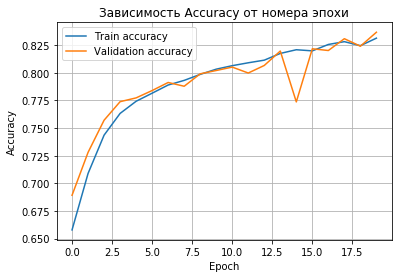

In [10]:
fig, ax = plt.subplots() # зададим область графика
ax.plot(train_accuracy_history, label='Train accuracy') # печатаем график изменения accuracy на тренировочной выборке
ax.plot(val_accuracy_history, label='Validation accuracy') # печатаем график изменения accuracy на валидационной выборке
ax.grid() # добавляем сетку
ax.set_title('Зависимость Accuracy от номера эпохи') # печатаем заголовок графика
ax.set_xlabel('Epoch') # подписываем ось x
ax.set_ylabel('Accuracy') # подписываем ось y
ax.legend() # печатаем легенду
plt.show()

In [11]:
torch.save(model, './model') # сохраняем модель в папку с ноутбуком

Проверим как работает наша модель.

In [12]:
def pred_img(path): # определяем функцию для предсказания пола человека по фотографии, входной параметр - путь к файлу
    transform = transforms.Compose([transforms.RandomResizedCrop(64),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # задаем, то как трансформировать изображение
    img_load = Image.open(path).convert('RGB') # открываем файл с изображением 
    img = transform(img_load) # производим преобразование 
    img = img.unsqueeze(0).float() # добавляем добавляем один слой, т.к. мадоель ожидает тензор размером [batch, 3, 64, 64]
    prediction = model.forward(img).argmax(dim=1) # опеределяем пол человека на фотографии
    plt.imshow(np.array(img_load)) # печатаем фотографию
    plt.show()
    print(classes[prediction]) # печатаем пол

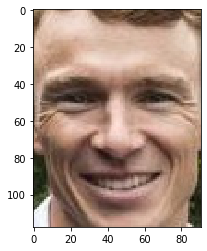

male


In [13]:
n = random.randint(0, len(dataset)) # случайно выбираем фотографию из датасета
pred_img(dataset.samples[n][0])